# 비전공자를 위한 AI 딥러닝(Deep Learning)


####  원과 밖 상 (비선형)

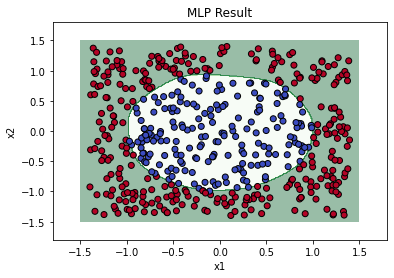

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 시행착오를 정말 많이 겪었다.결국 혼자힘으로 해결하지 못하고 GPT의 힘을 빌려서..
# 계산량등을 줄이기 위해서 사실 처음 의도와는 많이 달라졌지만 핵심은 비선형분리


#데이터 생성 (원 안의 데이터와 / 원 밖의 데이터로 구별해서 만든다)
def generate_dataset(num_samples):
    dataset = []
    x1 = np.random.uniform(-1.4, 1.4, num_samples)  # num_samples 개의 랜덤한 x1 값 생성
    x2 = np.random.uniform(-1.4, 1.4, num_samples)  # num_samples 개의 랜덤한 x2 값 생성
    
    for i in range(num_samples):
        r_squared = x1[i] ** 2 + x2[i] ** 2
        if r_squared < 1:
            dataset.append([x1[i], x2[i], 0])
        else:
            dataset.append([x1[i], x2[i], 1])

    return np.array(dataset)
# 사실 데이터 생성 이거 정말 시간 많이 걸렸다. 여기에만 2~3시간 쏟아부었고 중간에 형태가 정말 많이 바꼈다.
# 처음부터 github 이용해서 작업기록 남겨놓았으면 이런 생각이 든다. 정말 변천사 기록해뒀어야 하는데..
# 시간 날린거지만 그냥 내가 파이썬에 익숙하지 않아서 이것저것 배웠다고 생각하자


# 시그모이드 활성화 함수구현 
def sigmoid(x):
    return 1 / (1 + np.exp(-x)) 


# 다층 퍼셉트론 구현 (국비교육 받았을 때 지겹게 봤었던것 이제 직접 구현할 줄 알아야 하는데..
class MLP:
    def __init__(self, input_dim, hidden_dim, output_dim) :
        #input + hiden(하이퍼 파라미터) + 아웃풋 기본 구성
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        # 히든 레이어를 몇개 할 것인지 결정 어려운 문제가 아니므로 2개면 충분
        self.weights1 = np.random.randn(self.input_dim, self.hidden_dim) 
        self.bias1 = np.zeros((1, self.hidden_dim))
        self.weights2 = np.random.randn(self.hidden_dim, self.output_dim)
        self.bias2 = np.zeros((1, self.output_dim))
        #사실 이 당시에 왜 저기에 저렇게 dim 이 되는지도 모르고 무작정 외웠는데 지금 보니까 너무 명쾌하다.

        
    def forward(self, X):
        # 입력 -> 은닉층
        self.hidden_input = np.dot(X, self.weights1) + self.bias1
        self.hidden_output = sigmoid(self.hidden_input)

        # 은닉층 -> 출력층
        self.output_input = np.dot(self.hidden_output, self.weights2) + self.bias2
        self.output_output = sigmoid(self.output_input)

        return self.output_output

    def train(self, X, y, epochs=1000, learning_rate=0.1):
        for epoch in range(epochs):
            # Forward propagation
            output = self.forward(X)

            # Backpropagation
            error = y - output
            output_delta = error * (output * (1 - output)) #여기까지는 쉬웠다.
            hidden_error = output_delta.dot(self.weights2.T) #여기서부터 이게 맞았는가 조금 헷갈리네 다시 정리해야겠다.
            hidden_delta = hidden_error * (self.hidden_output * (1 - self.hidden_output)) #역전파 부분에서 체인룰 이런거 구현하려니까 헷갈리네

            # Weight updates 이 부분 전체적으로 헷갈린다 특히 keepdims 에러 이거 별 거 아닌데 가끔 깜빡할때가 많단 말이야
            self.weights2 += self.hidden_output.T.dot(output_delta) * learning_rate 
            self.bias2 += np.sum(output_delta, axis=0, keepdims=True) * learning_rate
            self.weights1 += X.T.dot(hidden_delta) * learning_rate
            self.bias1 += np.sum(hidden_delta, axis=0, keepdims=True) * learning_rate

    def predict(self, X):
        return np.round(self.forward(X))

# 데이터셋 생성
num_samples = 500
dataset = generate_dataset(num_samples)
X = dataset[:, :2]  # 좌표
y = dataset[:, 2].reshape(-1, 1)  # 안과 밖

# MLP 모델 초기화 및 학습
mlp = MLP(input_dim=2, hidden_dim=10, output_dim=1)  # 은닉층 노드 수는 적절히 조정 가능
mlp.train(X, y, epochs=2000, learning_rate=0.1)

# 결정 경계 시각화
x1_min, x1_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
x2_min, x2_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.01),
                       np.arange(x2_min, x2_max, 0.01)) 
#meshgrid는 진짜 시각화 하려면 필수수준이네.. 근데 이게 맞는건가??  내가 준 데이터가 아니라 지멋대로 새로 데이터 만들어서 하는거 아님?
Z = mlp.predict(np.c_[xx1.ravel(), xx2.ravel()])
Z = Z.reshape(xx1.shape)

plt.contourf(xx1, xx2, Z, alpha=0.4, cmap='Greens')  # 초록색으로 결정 경계 표시
plt.scatter(X[:, 0], X[:, 1], c=dataset[:, 2], cmap='coolwarm', edgecolor='k')
plt.title('MLP Result')
plt.xlabel('x1')
plt.ylabel('x2')



# 넓은 범위로 x축과 y축 설정
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)

plt.show()

#결국 이건 내가 처음 사용한 데이터가 아니라 학습으로 만들어진 파라미터를 기반으로 새로운 데이터를 만들어서 시각화 하는 것
#내가 의도한것이랑은 다르다.

# 딥러닝 부분은 국비 때 배워서 너무 간단했다.  (라고 생각했지만..) 역전파 부분이랑 가중치 업데이트 하는 부분 특히 keepdims 이 부분은 여전히 헷갈리네  

## 다만 모의데이터셋 만드는데 3~4시간 태운게..

# meshgrid meshgrid meshgrid 